# Checking simplified dynamics

In [1]:
using LinearAlgebra
using PyCall
using PyPlot
include("../scripts/Params.jl");
include("../scripts/SphereConeVehicleModel.jl");

## Design parameters

In [2]:
params = Dict("r_min" => 0.001, # smallest radius of the cone [m]
              "r_max" => 1.30, # largest radius of the cone [m]
              "δ" => 43 / 360 * 2 * pi, # opening angle of the cone [rad]
              "m" => 569.7, # mass of the Phoenix entry system [kg]
              "x_g" => -0.150, # axial center-of-gravity location [m]
              "c" => 1.20, # distance between the radial axis and the cluster of thrusters[m]
              "F_max" => 36.0, # maximum force applied by the thrusters [N]
              "Jxx" => 293.15, # Phoenix entry system [kg.m^2]
              "Jyy" => 184, # Phoenix entry system [kg.m^2]
              "Jzz" => 208.02, # Phoenix entry system [kg.m^2]
              "Jxy" => 0.451, # Phoenix entry system [kg.m^2]
              "Jxz" => -4.424, # Phoenix entry system [kg.m^2] 
              "Jyz" => 0.372, # Phoenix entry system [kg.m^2]
              "g" => 3.711, # Mars gravity [m^2.s^-1]
              "h" => 10800, # Atmospheric Scale Height [m]
              "ρ_0" => 0.020, # Surface density of Mars atmosphere [kg.m^-3]
              "r_p" => 3389.5e3, # Volumetric mean radius of Mars [m]
              "ω_p" => [0, 0, 7.088e-05]) # Angular velocity of Mars [rad.s^-1]
complete_params!(params);

In [3]:
function entry_vehicle_mrp_simplified_dynamics!(ẋ, X, u, params)
    ## States: X ∈ R^13; q = [s;v]
    # x
    # y
    # z
    # q0
    # q1
    # q2
    # q3
    # xdot
    # ydot
    # zdot
    # omega1
    # omega2
    # omega3

    x = X[1:3]
    r = X[4:6] # MRP
    v = X[7:9]
    ω = X[10:12]

    # Parameters
    r_min = params["r_min"] # smallest radius of the cone [m]
    r_max = params["r_max"] # largest radius of the cone [m]
    l = params["l"] # largest radius of the cone [m]
    m = params["m"] # mass of the Phoenix entry system [kg]
    x_g = params["x_g"] # axial center-of-gravity location [m]
    Jxx = params["Jxx"] # Phoenix entry system [kg.m^2]
    Jyy = params["Jyy"] # Phoenix entry system [kg.m^2]
    Jzz = Jyy # Phoenix entry system [kg.m^2]
    Jxy = 0.0 # Phoenix entry system [kg.m^2]
    Jxz = 0.0 # Phoenix entry system [kg.m^2]
    Jyz = 0.0 # Phoenix entry system [kg.m^2]
    g = params["g"] # Mars gravity [m^2.s^-1]
    ρ_0 = params["ρ_0"] # Surface density of Mars atmosphere [kg.m^-3]
    ω_p = [0, 0, 0] # Angular velocity of Mars [rad.s^-1]
    J = Matrix([Jxx Jxy Jxz; Jxy Jyy Jyz; Jxz Jyz Jzz])# Inertia matrix [kg.m^2]
    Jinv = inv(J) # inverted inertia matrix [kg^-1.m^-2]

    # Rotation
    R = mrptodcm(r)

    # Mars atmosphere model
    # We simplify the atmosphere model to a constant density.  
    ρ_inf = ρ_0

    # Freestream Velocity
    # Static fluid assumption
    V_inf = - R' * (v + cross(x, ω_p)) #- qrot(qconj(q), v + cross(x, ω_p))
    println("V_inf ", V_inf)
    # Compute the force and torque applied of the vehicle at the center of mass.
    F_hat = params["F_hat"]
    τ_hat = params["τ_hat"]
    F_a, τ_a = illuminated_aerodynamics_online(F_hat, τ_hat, ρ_inf, V_inf)

    # Control forces and moments in body_frame
    F_c, τ_c = reaction_control_system(u, params)

    # Forces and moments in body-frame
    F = F_a + F_c
    τ = τ_a + τ_c

    ẋ[1:3] = v # velocity in world frame
    ẋ[4:6] = 0.25 * ((1 - r'*r) * ω - 2 * cross(ω,r) + 2 * (ω' * r) * r) #  0.5 * qmult(q, [0; ω]) #quaternion derivative
    ẋ[7:9] = [g, 0, 0] + (1 / m) * (R * F) #[g, 0, 0] + (1 / m) * qrot(q, F) #acceleration in world frame
    println("(R * F) ", (R * F))

    #Euler's equation: I*ω + ω x I*ω = constraint_decrease_ratio
    ẋ[10:12] = Jinv * (τ - cross(ω , J * ω))
    return ẋ
end

function entry_vehicle_mrp_simplified_dynamics(X, u, params)
    ẋ = zeros(13,1)
    entry_vehicle_mrp_simplified_dynamics!(ẋ, X, u, params)
    return ẋ
end


function mrptodcm(mrp)
    # Converts a vector of Modified Rodrigues Parameters to a Rotation Matrix
    mrp2 = mrp' * mrp;
    S = [0       -mrp[3] mrp[2];
         mrp[3]  0       -mrp[1];
         -mrp[2] mrp[1]  0]
    I = diagm(0=>fill(1., 3))
    R = I + (8 * S * S + 4 * (1 - mrp2) * S) / ((1 + mrp2)^2)
    println(R'R)
    return R
end




mrptodcm (generic function with 1 method)

## Simplified Dynamics Model
- We assume flat planet model, gravity acceleration is directed along the x axis.
- We assume constant uniform of the atmosphere.
- We assume that the fluid is static.

In [17]:
# Initial conditions

# Iniitial altitude
x_0 = - 125000.0 - 3389.5e3

# Initial speed
v_0 = 5500 * [1, 0, 0]

# Initial orientation
q_0 = [1, 0, 0, 0]
q_0 = [0.999, 0, 0, 0.04]
q_0 = q_0 / norm(q_0)
    
θ = 0.0
r = tan(θ / 4) .* [cos(θ), sin(θ), 0]
# Initial state
X_0 = [x_0, 0, 0, q_0[1], q_0[2], q_0[3], q_0[4], v_0[1], v_0[2], v_0[3], 0, 0, 0]
X_0_mrp = [x_0, 0, 0, r[1], r[2], r[3], v_0[1], v_0[2], v_0[3], 0, 0, 0]

12-element Array{Float64,1}:
   -3.5145e6
    0.0     
    0.0     
    0.0     
    0.0     
    0.0     
 5500.0     
    0.0     
    0.0     
    0.0     
    0.0     
    0.0     

## Derivative 

In [18]:
u = zeros(12,1)
X_dot = entry_vehicle_simplified_dynamics(X_0, u, params)

V_inf[-5482.39, 439.735, -0.0]
qrot(q, F)[-3.08637e6, -2.39809e5, 1.53838e-7]


13×1 Array{Float64,2}:
  5500.0                   
     0.0                   
     0.0                   
     0.0                   
     0.0                   
     0.0                   
     0.0                   
 -5413.819395860953        
  -420.9399275760251       
     2.7003344671939095e-10
    -9.879282986432783e-16 
     5.255308161877594e-6  
  -196.69962487262052      

In [19]:
X_dot = entry_vehicle_mrp_simplified_dynamics(X_0_mrp, u, params)


[1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
V_inf [-5500.0, 0.0, 0.0]
(R * F) [-3.11526e6, -1.54747e-7, 1.54781e-7]


13×1 Array{Float64,2}:
  5500.0                   
     0.0                   
     0.0                   
     0.0                   
     0.0                   
     0.0                   
 -5464.542686821003        
    -2.71629070683997e-10  
     2.716880214835691e-10 
    -1.0232678328552838e-15
    -9.231070195288669e-6  
     2.228469897145594e-5  
     0.0                   

V_inf[-5482.39, 439.735, -0.0]
qrot(q, F)[-1.25706e5, 2.38989e5, -0.000229848]
V_inf[-5482.39, 439.735, -0.0]
qrot(q, F)[-1.39454e5, 2.36765e5, -0.000444997]
V_inf[-5482.39, 439.735, -0.0]
qrot(q, F)[-1.54095e5, 2.34397e5, -0.000180964]
V_inf[-5482.39, 439.735, -0.0]
qrot(q, F)[-1.6962e5, 2.31887e5, 0.000343666]
V_inf[-5482.39, 439.735, -0.0]
qrot(q, F)[-186021.0, 2.29234e5, -1.24125e-5]
V_inf[-5482.39, 439.735, -0.0]
qrot(q, F)[-2.03287e5, 2.26442e5, 0.000366553]
V_inf[-5482.39, 439.735, -0.0]
qrot(q, F)[-2.21407e5, 2.23512e5, -5.19475e-6]
V_inf[-5482.39, 439.735, -0.0]
qrot(q, F)[-240370.0, 220445.0, 0.000303923]
V_inf[-5482.39, 439.735, -0.0]
qrot(q, F)[-2.60165e5, 2.17244e5, 0.000126307]
V_inf[-5482.39, 439.735, -0.0]
qrot(q, F)[-2.8078e5, 2.1391e5, -0.000177097]
V_inf[-5482.39, 439.735, -0.0]
qrot(q, F)[-3.02203e5, 2.10445e5, 5.7834e-5]
V_inf[-5482.39, 439.735, -0.0]
qrot(q, F)[-3.2442e5, 2.06853e5, -0.000156301]
V_inf[-5482.39, 439.735, -0.0]
qrot(q, F)[-3.47417e5, 2.03133e5, 0.0

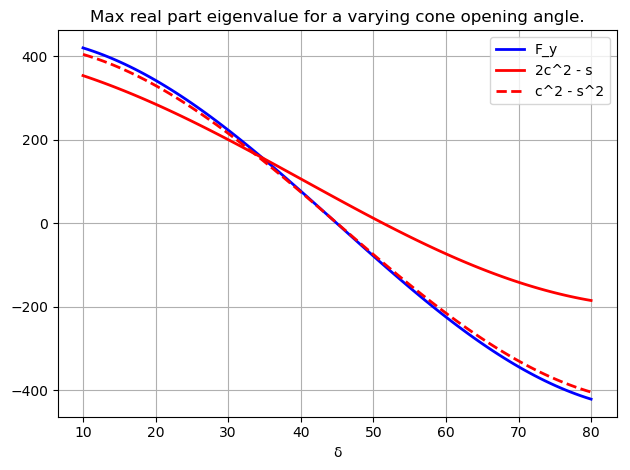

[-5482.39, 439.735, -0.0]
qrot(q, F)[-3.02605e6, -2.30055e5, 1.95545e-7]
V_inf[-5482.39, 439.735, -0.0]
qrot(q, F)[-3.04245e6, -2.32708e5, 3.70336e-7]
V_inf[-5482.39, 439.735, -0.0]
qrot(q, F)[-3.05798e6, -2.35218e5, -1.56811e-11]
V_inf[-5482.39, 439.735, -0.0]
qrot(q, F)[-3.07262e6, -2.37586e5, 1.64439e-7]
V_inf[-5482.39, 439.735, -0.0]
qrot(q, F)[-3.08637e6, -2.39809e5, 1.53838e-7]


100-element Array{Float64,1}:
  419.4988671375793 
  415.5963069262503 
  411.4401491609392 
  407.03292710032116
  402.37732506752593
  397.47617907784723
  392.33247606447503
  386.94934769152235
  381.3300733341882 
  375.4780749975735 
  369.39691930670614
  363.09030955035394
  356.56208726335177
    ⋮               
 -364.5313690238552 
 -370.83797885070595
 -376.9191346537924 
 -382.77113217824837
 -388.39040672802895
 -393.77353536874193
 -398.91723901119724
 -403.81838441111756
 -408.4739860758702 
 -412.8812080853448 
 -417.0373658141596 
 -420.9399275760251 

In [20]:
function plot_F_y(params, num_nodes; display=true)
    δ_vect = range(10, stop=80, length=num_nodes) / 360 * 2 * pi
    F_y = zeros(num_nodes)
    for i=1:num_nodes
        δ = δ_vect[i]
        params["δ"] = δ
        complete_params!(params)
        F_y[i] = entry_vehicle_simplified_dynamics(X_0, u, params)[9]
        
    end
    plot(δ_vect.*(360/2/pi), F_y, color="blue", linewidth=2.0, linestyle="-", label="F_y")
    plot(δ_vect.*(360/2/pi), 200*(2*cos.(δ_vect).^2 - sin.(δ_vect)), color="red", linewidth=2.0, linestyle="-", label="2c^2 - s")
    plot(δ_vect.*(360/2/pi), 430*(cos.(δ_vect).^2 - sin.(δ_vect).^2), color="red", linewidth=2.0, linestyle="--", label="c^2 - s^2")
    legend()
    xlabel("δ")
    title("Max real part eigenvalue for a varying cone opening angle.")
    grid("on")
    if display 
        tight_layout()
        show()
    end
    return F_y
end

num_nodes = 100
plot_F_y(params, num_nodes)